In [1]:
from tf_helper import *

2022-10-03 10:36:07.476062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 10:36:07.568404: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-03 10:36:07.923391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2022-10-03 10:36:07.923437: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
N = 56
padx = pady = N // 2

input_shape = (N, N, 1)#datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

filt = fourier.lowpass_g(.4, np.ones(N))
probe = gf(((np.einsum('i,j->ij', filt, filt)) > .5).astype(float), 2)
tprobe = (tf.convert_to_tensor(probe, tf.float32)[..., None])

datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

def do_forward(sequential = None):
    """
    zero-pad the real-space object and then fourier transform it
    """
    if sequential is None:
        sequential = tfk.Sequential([])
        
    padder = tfkl.ZeroPadding2D((padx // 2, padx // 2))

    sequential.add(padder)
    sequential.add(tfk.Input(shape = (N, N, 1)))
    
    sequential.add(Lambda(lambda inp: tprobe * inp))
    
    sequential.add(Lambda(lambda resized: (fft2d(
        tf.squeeze(tf.cast(resized, tf.complex64))
    ))))
    sequential.add(Lambda(lambda X: tf.math.real(tf.math.conj(X) * X) / N**2))
    sequential.add(Lambda(lambda psd: 
                          tf.expand_dims(
                              tf.math.sqrt(
            fftshift(psd, (-2, -1))
                                   ), 3)))
    return sequential

def _preprocess(sample):
    image = tf.cast(tf.image.resize(sample['image'], [N, N]), 
                    tf.float32) / 255.  # Scale to unit interval.
#     print(image.shape)
#     image = image * tprobe
#     print(image.shape, tf.convert_to_tensor(probe, tf.float32)[..., None].shape)
    rmod = do_forward(do_resize(N))
    rmod.compile(loss='mse')
    orig = tf.identity(image)
    image = rmod(image)#rmod.predict(image)
    return image, image, orig


2022-10-03 10:36:12.853251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 10:36:12.854188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 10:36:12.854353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 10:36:12.854467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
train_dataset = (datasets['train']
                 .batch(256)
                 .map(_preprocess)
                 .cache()
                 .prefetch(tf.data.AUTOTUNE)
                 .shuffle(int(10e3)))


eval_dataset = (datasets['test']
                .batch(256)
                .map(_preprocess)
                .cache()
                .prefetch(tf.data.AUTOTUNE))

In [4]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

In [5]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tf.keras.layers.BatchNormalization(),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])


In [19]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tf.keras.layers.BatchNormalization(),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    
#     tfkl.Conv2DTranspose(base_depth, 5, strides=2,
#                          padding='same', activation=tf.nn.leaky_relu),
#     tfkl.Conv2DTranspose(base_depth, 5, strides=1,
#                          padding='same', activation=tf.nn.leaky_relu),
    

    tf.keras.layers.BatchNormalization(),
#     tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
#                 padding='same', activation=None),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=tf.nn.sigmoid),
    
#      tfkl.Reshape((input_shape)),
   tfkl.Reshape((input_shape[0] // 2, input_shape[1] // 2, 1)),

    # impose real space support
#     Lambda(lambda x: add_support(x),
#                     name='masked_obj')
    
])



decoder2 = tfk.Sequential([
    tfkl.InputLayer(input_shape = tf.TensorShape([None, None, None])),
#     Lambda(lambda x: tprobe * x),
#     Lambda(lambda x: add_support(x),
#             name='masked_obj'),
    do_forward(),
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc = t, scale = 0.003))),
])


In [20]:
vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder2(decoder(encoder.outputs[0])))

In [21]:
for layer in decoder.layers:
    print(layer.name, layer.output_shape)

reshape_2 (None, 1, 1, 16)
batch_normalization_3 (None, 1, 1, 16)
conv2d_transpose_6 (None, 7, 7, 64)
conv2d_transpose_7 (None, 7, 7, 64)
conv2d_transpose_8 (None, 14, 14, 64)
conv2d_transpose_9 (None, 14, 14, 32)
conv2d_transpose_10 (None, 28, 28, 32)
conv2d_transpose_11 (None, 28, 28, 32)
batch_normalization_4 (None, 28, 28, 32)
conv2d_6 (None, 28, 28, 1)
reshape_3 (None, 28, 28, 1)


In [22]:
for layer in decoder2.layers:
    print(layer.name, layer.output_shape)

sequential_5 None
distribution_lambda_1 (None, None)


In [25]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=negloglik)

In [28]:
_ = vae.fit(train_dataset,
            epochs=5,
            validation_data=eval_dataset)

Epoch 1/5
235/235 [==============================] - ETA: 0s - loss: 12521.0381WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 11s 46ms/step - loss: 12521.0381 - val_loss: 12615.7832
Epoch 2/5
235/235 [==============================] - ETA: 0s - loss: 12331.8066WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 11s 46ms/step - loss: 12331.8066 - val_loss: 12630.7197
Epoch 3/5
235/235 [==============================] - ETA: 0s - loss: 12141.0166WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 11s 47ms/step - loss: 12141.0166 - val_loss: 12288.7275
Epoch 4/5
235/235 [==============================] - ETA: 0s - loss: 11993.1787WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 11s 47ms/step - loss: 11993.1787 - val_loss: 12229.7637
Epoch 5/5
235/235 [==============================] - ETA: 0s - loss: 11827.9971WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 11s 46ms/step - loss: 11827.9971 - val_loss: 12053.4092


In [17]:
import matplotlib.pyplot as plt

def display_imgs(x, y=None, log = False, cbar = False):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  #plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 2))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    if log:
        axs.flat[i].imshow(np.log(.01 + x[i].squeeze()), interpolation='none', cmap='jet')
    else:
        axs.flat[i].imshow((x[i].squeeze()), interpolation='none', cmap='jet')
    axs.flat[i].axis('off')
  if cbar:
    plt.colorbar()
  plt.show()
  plt.close()
  plt.ion()

Input diffraction:


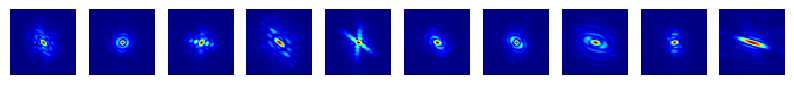

Reconstructed diffraction (modes):


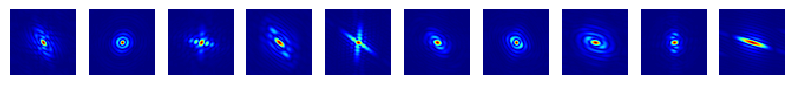

True object


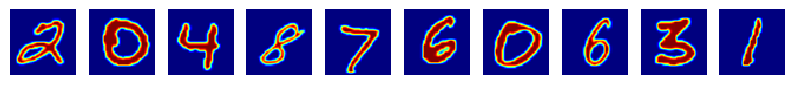

Reconstructed object (mode)


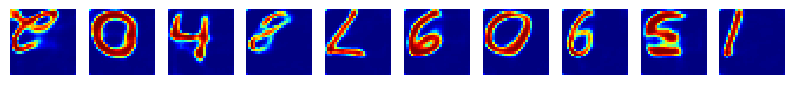

Reconstructed object variance


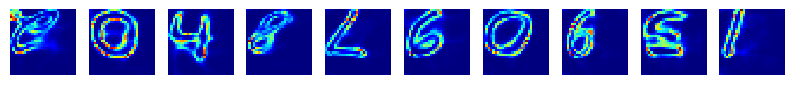

Reconstructed diffraction variance


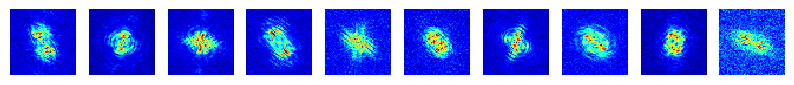

0.013174026890657949

In [29]:
x_orig = next(iter(eval_dataset))[2][:10]
# x_orig = next(iter(eval_dataset))[2][10:20]

# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
# x = next(iter(eval_dataset))[0][10:20]

# x_orig = next(iter(eval_dataset))[2][10:20]

# # We'll just examine ten random digits.
# x = next(iter(eval_dataset))[0][10:20]

xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(20, 20)

print('Input diffraction:')
display_imgs(x)

# print('Decoded Random Samples (top: reconstruction; bottom: diffraction):')
# tmp = decoder(encoder(x))
# display_imgs(tmp)
# display_imgs(decoder2(tmp).sample())

print('Reconstructed diffraction (modes):')
display_imgs(xhat.mode())

# print('Decoded Means:')
# display_imgs(xhat.mean())

print("True object")
display_imgs((x_orig))

print("Reconstructed object (mode)")
display_imgs((decoder(encoder(x).mean())))

print('Reconstructed object variance')
tmp = tf.stack([decoder(encoder(x)) for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))

print('Reconstructed diffraction variance')
tmp = tf.stack([vae(x).sample() for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))


# display_imgs(tf.abs(decoder(encoder(x).mode()) - resize(x_orig)))

np.percentile(np.array(tmp).std(axis = 0).ravel(), 99.9)

